In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


df = pd.read_csv("ASOS_Daily_2000_2004.csv")

df = df[["tm", "avgTa", "maxTa", "sumRn", "avgWs", "avgRhm"]]
df["tm"] = pd.to_datetime(df["tm"], format = "%Y-%m-%d")
df.fillna(0, inplace = True)
# index to datetime index

# the data is not complete
# features of data is str format
# so we have to change the data type
# first, we need to fill the missing data
df = df.applymap(lambda x: 0 if x == "" else x)
df = df.astype({"avgTa": np.float32, "maxTa": np.float32, "sumRn": np.float32, "avgWs": np.float32, "avgRhm": np.float32})

df

,tm,avgTa,maxTa,sumRn,avgWs,avgRhm
0,2000-01-01,5.5,9.9,0.0,2.3,63.500000
1,2000-01-02,4.2,6.9,6.0,3.6,74.300003
2,2000-01-03,-2.2,0.1,0.0,2.7,54.099998
3,2000-01-04,0.3,4.3,0.0,1.7,48.599998
4,2000-01-05,2.8,4.6,18.4,3.2,83.599998
...,...,...,...,...,...,...
1822,2004-12-27,-4.0,-0.4,0.0,2.5,44.299999
1823,2004-12-28,-4.9,-2.5,0.0,2.0,41.500000
1824,2004-12-29,-5.7,-2.2,0.0,2.5,45.000000
1825,2004-12-30,-4.6,-0.8,0.0,1.8,49.099998


In [3]:
series = df.loc[:, "sumRn"]
series.index = df.loc[:, "tm"]
series 

tm
2000-01-01     0.0
2000-01-02     6.0
2000-01-03     0.0
2000-01-04     0.0
2000-01-05    18.4
              ... 
2004-12-27     0.0
2004-12-28     0.0
2004-12-29     0.0
2004-12-30     0.0
2004-12-31     0.0
Name: sumRn, Length: 1827, dtype: float32

<Figure size 700x2000 with 0 Axes>

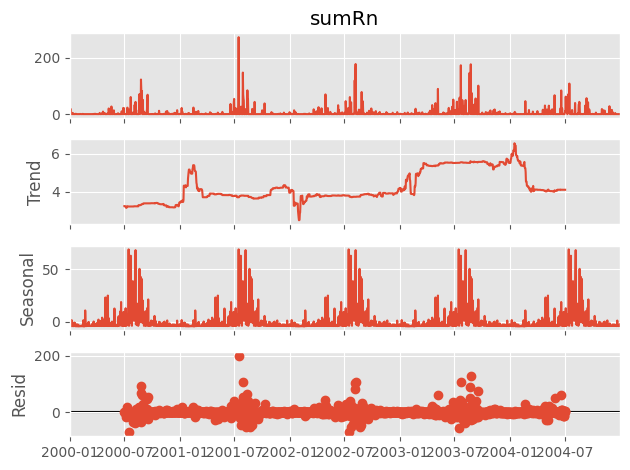

In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose
plt.style.use("ggplot")
result = seasonal_decompose(series, model = "additive", period = int(365))

plt.figure(figsize = (7, 20))
result.plot()
plt.show()


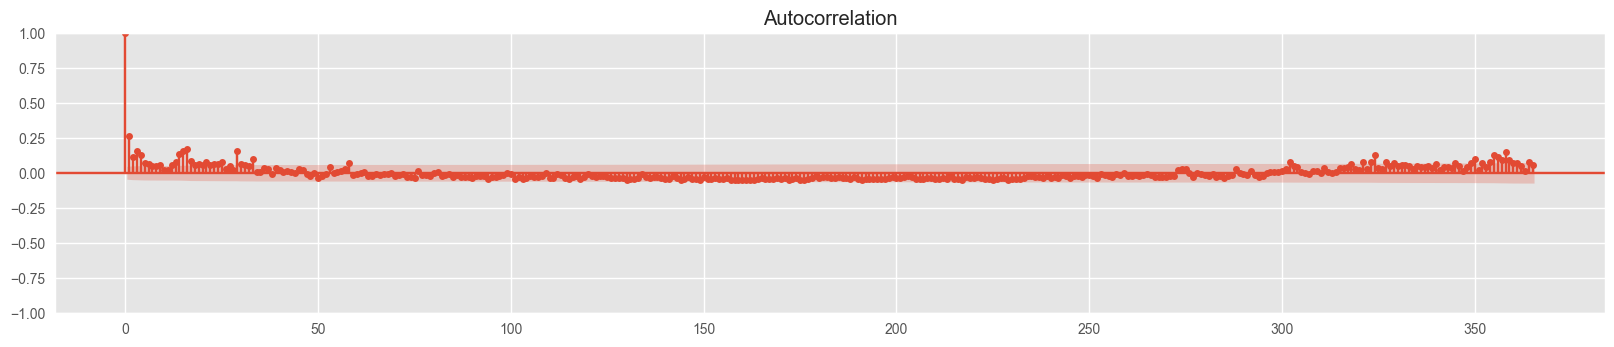

In [76]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
fig = plt.figure(figsize = (20, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(series, lags = 365, ax = ax1)
# series = df["sumRn"]
# plot_acf(series)
# plot_pacf(series)
# plt.show()

In [82]:
from statsmodels.tsa.stattools import adfuller
def adf_check(time_series):
    result = adfuller(time_series)
    print("Augmented Dicky-Fuller Test")
    labels = ["ADF Test Statistic", "p-value", "# of lags", "Num of Observations Used"]
    for value, label in zip(result, labels):
        print(label + " : " + str(value))
    if result[1] <= 0.05:
        print("Strong evidence against null hypothesis")
        print("reject null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against null hypothesis")
        print("Fail to reject null hypothesis")
        print("Data has a unit root, it is non-stationary")

result = adfuller(series)
print("ADF Statistic: %f" % result[0])
print("p-value: %f" % result[1])
for key, value in result[4].items():
    print("\t%s: %.3f" % (key, value))


ADF Statistic: -6.496696
p-value: 0.000000
	1%: -3.434
	5%: -2.863
	10%: -2.568


In [86]:
def get_diff(series, lag = 1):
    diff = series - series.shift(lag)
    diff.dropna(inplace = True)
    return diff
diff = get_diff(series, lag = int(4))


adf_check(diff)

Augmented Dicky-Fuller Test
ADF Test Statistic : -12.650478854334649
p-value : 1.3718455637304933e-23
# of lags : 25
Num of Observations Used : 1797
Strong evidence against null hypothesis
reject null hypothesis
Data has no unit root and is stationary


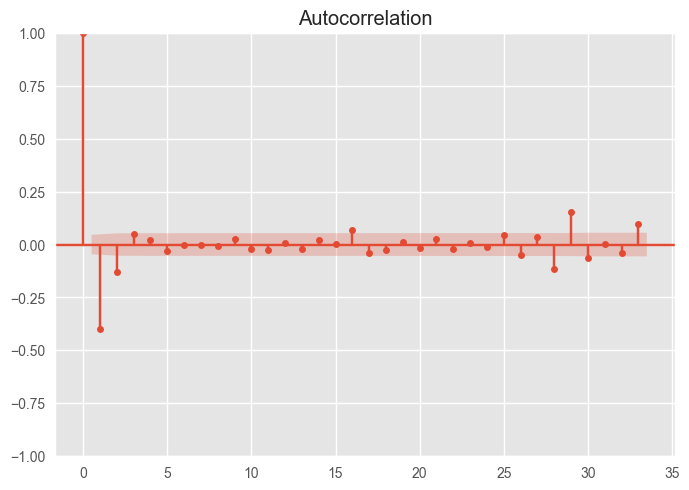

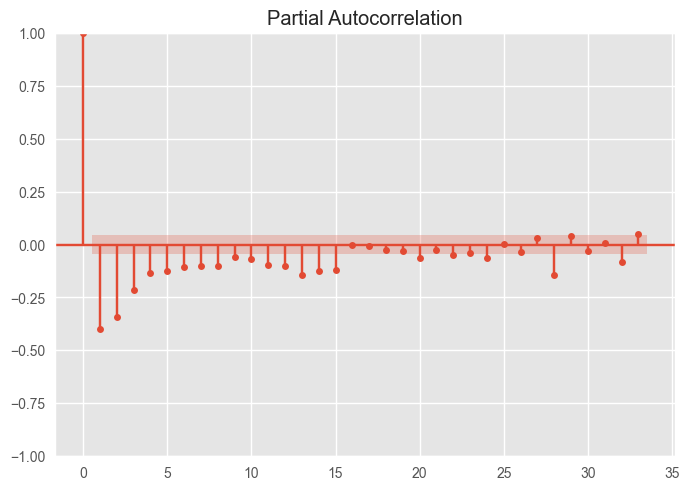

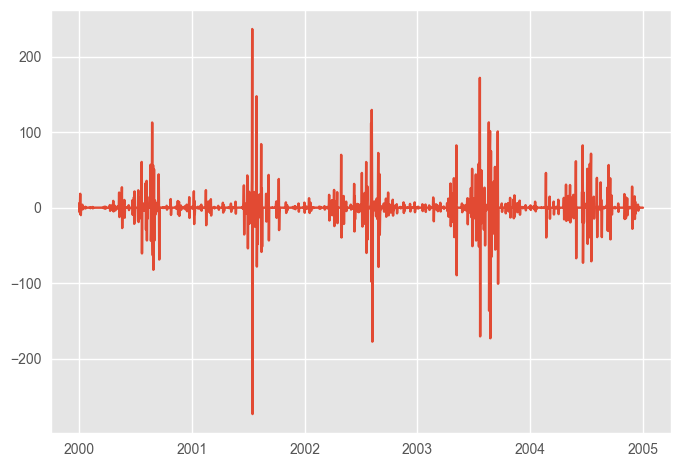

In [80]:
plot_acf(diff)
plot_pacf(diff)
plt.show()

plt.plot(diff)

c:\Users\hj\makemore\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MSE:  28.6582344764382
MAE:  3.0828370059228933
MAPE:  6531377144682548.0
RMSE:  5.353338628971476
R2:  -0.0970043812147634


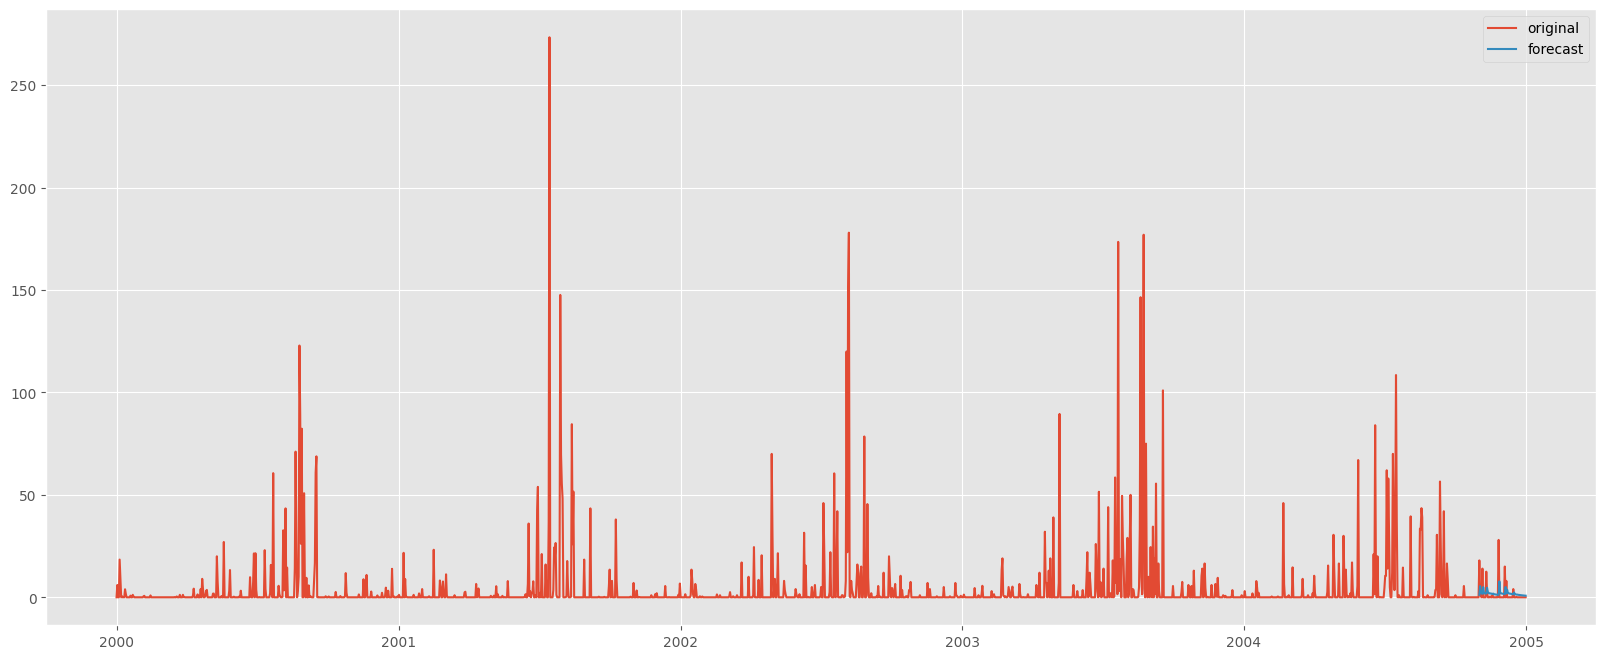

In [9]:
from statsmodels.tsa.arima.model import ARIMA
from datetime import datetime

model = ARIMA(series, order=(1,1,1), freq = "D")
model_fit = model.fit()

# predict

start_index = datetime(2004, 11, 1)
end_index = datetime(2004, 12, 31)

forecast = model_fit.predict(start = start_index, end = end_index, typ = "levels")
forecast.index = pd.date_range(start = start_index, end = end_index, freq = "D")
plt.figure(figsize = (20, 8))
plt.plot(df.loc[:, "tm"], df.loc[:, "sumRn"], label = "original")
plt.plot(forecast, label = "forecast")
plt.legend()

# evaluate the model

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
import math

print("MSE: ", mean_squared_error(df.loc[:, "sumRn"][-len(forecast.index):], forecast))
print("MAE: ", mean_absolute_error(df.loc[:, "sumRn"][-len(forecast.index):], forecast))
print("MAPE: ", mean_absolute_percentage_error(df.loc[:, "sumRn"][-len(forecast.index):], forecast))
print("RMSE: ", math.sqrt(mean_squared_error(df.loc[:, "sumRn"][-len(forecast.index):], forecast)))
print("R2: ", r2_score(df.loc[:, "sumRn"][-len(forecast.index):], forecast))





In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


df = pd.read_csv("ASOS_Daily_2000_2004.csv")
df2 = pd.read_csv("ASOS_Daily_2005_2010.csv")
df = pd.concat([df, df2], axis = 0)
df.reset_index(inplace = True)
df = df[["tm", "avgTa", "maxTa", "sumRn", "avgWs", "avgRhm"]]
df["tm"] = pd.to_datetime(df["tm"], format = "%Y-%m-%d")
df.fillna(0, inplace = True)
# index to datetime index

# the data is not complete
# features of data is str format
# so we have to change the data type
# first, we need to fill the missing data
df = df.applymap(lambda x: 0 if x == "" else x)
df = df.astype({"avgTa": np.float32, "maxTa": np.float32, "sumRn": np.float32, "avgWs": np.float32, "avgRhm": np.float32})

df

,tm,avgTa,maxTa,sumRn,avgWs,avgRhm
0,2000-01-01,5.5,9.9,0.0,2.3,63.500000
1,2000-01-02,4.2,6.9,6.0,3.6,74.300003
2,2000-01-03,-2.2,0.1,0.0,2.7,54.099998
3,2000-01-04,0.3,4.3,0.0,1.7,48.599998
4,2000-01-05,2.8,4.6,18.4,3.2,83.599998
...,...,...,...,...,...,...
4013,2010-12-27,-4.9,-2.1,0.2,2.3,72.300003
4014,2010-12-28,-2.6,-0.1,6.0,2.7,80.800003
4015,2010-12-29,-5.7,-2.1,0.1,2.2,55.400002
4016,2010-12-30,-6.1,-3.6,3.7,3.8,70.400002


In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json

from gluonts.dataset.repository import get_dataset, dataset_names
from gluonts.dataset.util import to_pandas

dataset = get_dataset("m4_hourly")


c:\Users\hj\makemore\venv\lib\site-packages\gluonts\json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


In [13]:
from gluonts.dataset.pandas import PandasDataset
dataset = PandasDataset(df, target="sumRn")
from gluonts.dataset.split import split


training_data, test_gen = split(dataset, offset=-60)
training_data, test_gen
test_data = test_gen.generate_instances(prediction_length=60, windows=3)
test_data

TestData(dataset=PandasDataset<size=1, freq=N, num_feat_dynamic_real=0, num_past_feat_dynamic_real=0, num_feat_static_real=0, num_feat_static_cat=0, static_cardinalities=[]>, splitter=OffsetSplitter(offset=-60), prediction_length=60, windows=3, distance=None, max_history=None)

In [11]:
entry = next(iter(dataset.train))
train_series = to_pandas(entry)
train_series.plot()
plt.grid(which="both")
plt.legend(["train series"], loc="upper left")
plt.show()


AttributeError: 'PandasDataset' object has no attribute 'train'

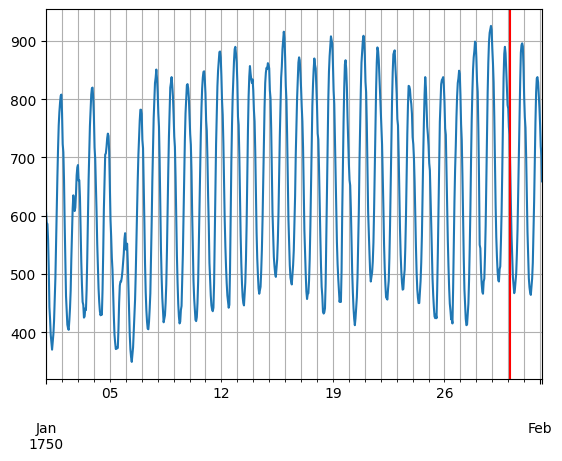

In [5]:
entry = list(dataset.test)
test_series = to_pandas(entry[0])
test_series.plot()
plt.axvline(train_series.index[-1], color='r') # end of train dataset
plt.grid(which="both")


In [6]:
df_drop = df.drop("tm", axis = 1)
prediction_length = int(365/4)
freq = "D"
custom_dataset = df_drop.to_numpy().T
start = pd.Period("01-01-2000", freq=freq) # <- TODO: use freq from dataset

In [7]:
from gluonts.dataset.common import ListDataset

train_ds = ListDataset(
    [{"target":x, "start": start} for x in custom_dataset[:, :-prediction_length]],freq=freq
)

test_ds = ListDataset(
    [{"target":x, "start": start} for x in custom_dataset], freq=freq
)


[{'target': array([ 5.5,  4.2, -2.2, ..., 13. , 14.6, 16. ], dtype=float32),
  'start': Period('2000-01-01', 'D')},
 {'target': array([ 9.9,  6.9,  0.1, ..., 16.8, 20.7, 21.4], dtype=float32),
  'start': Period('2000-01-01', 'D')},
 {'target': array([0., 6., 0., ..., 0., 0., 0.], dtype=float32),
  'start': Period('2000-01-01', 'D')},
 {'target': array([2.3, 3.6, 2.7, ..., 1.6, 1.6, 1.8], dtype=float32),
  'start': Period('2000-01-01', 'D')},
 {'target': array([63.5, 74.3, 54.1, ..., 61.1, 61.5, 66.1], dtype=float32),
  'start': Period('2000-01-01', 'D')}]

In [191]:
type(train_ds), type(dataset), type(dataset.train)

(list, gluonts.dataset.common.TrainDatasets, gluonts.itertools.Map)

48

In [10]:
from gluonts.mx import SimpleFeedForwardEstimator, Trainer

estimator = SimpleFeedForwardEstimator(
    num_hidden_dimensions=[10],
    prediction_length= prediction_length,
    context_length=prediction_length*2,
    trainer=Trainer(ctx="cpu", epochs=5, learning_rate=1e-3, num_batches_per_epoch=100),
)


ModuleNotFoundError: No module named 'mxnet'

In [11]:
import gluonts.mx


ModuleNotFoundError: No module named 'mxnet'